In [1]:
import os
from pathlib import Path
import pandas as pd

from jax_canveg import load_model

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


/global/cfs/cdirs/m1800/peishi/JAX-CanVeg/src/jax_canveg/shared_utilities/solver/fixed_point.py:69: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_jvp.defjvp` is deprecated in favour of `.def_jvp`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:, `None` was previously passed to indicate a symbolic zero tangent for all objects that weren't inexact arrays, but all inexact arrays always had an array-valued tangent. Now, `None` may also be passed to indicate that an inexact array has a symbolic zero tangent.
  def implicit_func_fixed_point_jvp(


In [2]:
# Plotting parameters
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
plt.rc('text', usetex = False)


# Locations of files and folders

In [7]:
sites = ["US-Bi1", "US-Me2", "US-Whs","US-Hn1"]
varns = ["LE", "NEE"]
cases = ["test-model", "PB-ML-0.5", "Hybrid-ML-0.5"]
subpara = [
    "ep",
    "par_reflect",
    "par_trans",
    "nir_reflect",
    "nir_trans",
    "bprime",
    "lleaf",
    "qalpha",
    "kball",
    "leaf_clumping_factor",
    "vcopt",
    "jmopt",
    "epsoil",
    "q10a",
    "q10b",
    "q10c",
]

subpara_labels = [
    "$ϵ$",
    "$r_{PAR}$",
    "$τ_{PAR}$",
    "$r_{NIR}$",
    "$τ_{NIR}$",
    "$m$",
    "$g_0$",
    "$ls$",
    "$α$",
    "$\Omega$",
    "$V_{c,\max,25}$",
    "$J_{\max,25}$",
    "$ϵ_{surf}$",
    "$a_r$",
    "$b_r$",
    "$c_r$",
]
varn_set = ["LE", "NEE"]

colors = {
    "PB": '#bdcf32', "Hybrid": '#27aeef', 
    "DNN": '#87bc45', "Obs": "black"
}

# Current directory
dir_mother = Path(os.getcwd())


# Load the sensitivity result

In [4]:
df_sa_set = {}

for site in sites:
    dir_model = dir_mother / site

    labels, df_sa_site = [], []
    for case in cases:
        dir_case = dir_model / case
        for varn in varn_set:
            f_sa = dir_case / f"sensitivity-{varn}.csv"
            df_sa = pd.read_csv(f_sa, index_col=0, parse_dates=True)
            df_sa = df_sa.rename(columns=dict(zip(subpara,subpara_labels)))
            df_sa_site.append(df_sa)
            labels.append(f"{varn}:{case}")
    df_sa_site = pd.concat(df_sa_site, axis=1, keys=labels)
    df_sa_set[site] = df_sa_site

# Ranking sensitivity

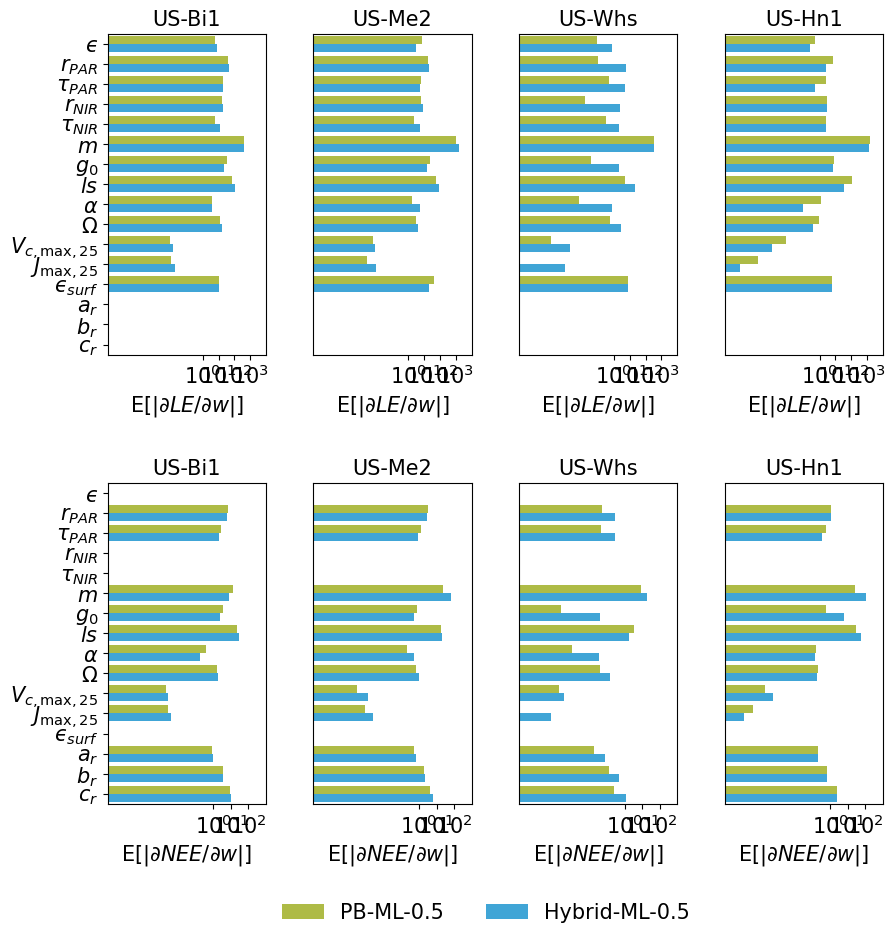

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
for j, site in enumerate(sites):
    for i, varn in enumerate(varn_set):
        ax = axes[i, j]
        df_sa = []
        for case in ["PB-ML-0.5", "Hybrid-ML-0.5"]:
            sa = df_sa_set[site][f"{varn}:{case}"][subpara_labels].copy()
            sa[sa.abs() > 1e5] = np.nan
            sa.replace([np.inf, -np.inf], np.nan, inplace=True)
            d = sa.abs().mean()
            d = d.reset_index()
            d.columns = ["Para", "Derivative"]
            d["Case"] = case
            df_sa.append(d)
        df_sa = pd.concat(df_sa)
        # sns.barplot(df_sa, x="body_mass_g", y="island", hue="island", legend=False)
        ax = sns.barplot(df_sa, y="Para", x="Derivative", hue="Case", ax=ax, 
                    palette=[colors['PB'], colors['Hybrid']], legend="full" if i==len(varn_set)-1 and j==len(sites)-1 else False)
        ax.set(ylabel="", xlabel=f"E[|$\partial {varn}/ \partial w$|]", title=f"{site}",
               xscale='log', xlim=[1e-6,1e4] if varn=='LE' else [1e-6,1e3],
               xticks=[1e0,1e1,1e2,1e3] if varn=='LE' else [1e0,1e1,1e2])
        if i==len(varn_set)-1 and j==len(sites)-1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, ncols=2, frameon=False, bbox_to_anchor=(-.1, -0.25), title="")
        if j != 0:
            ax.set_yticks([]);

plt.subplots_adjust(hspace=0.4, wspace=0.3)


# Directional Derivative

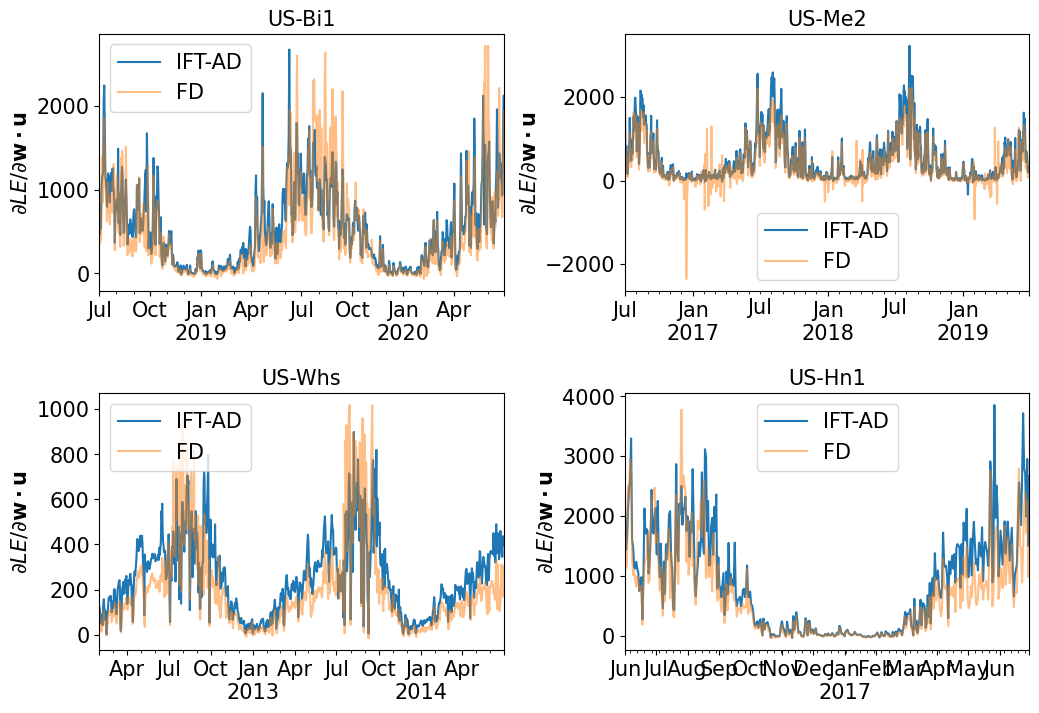

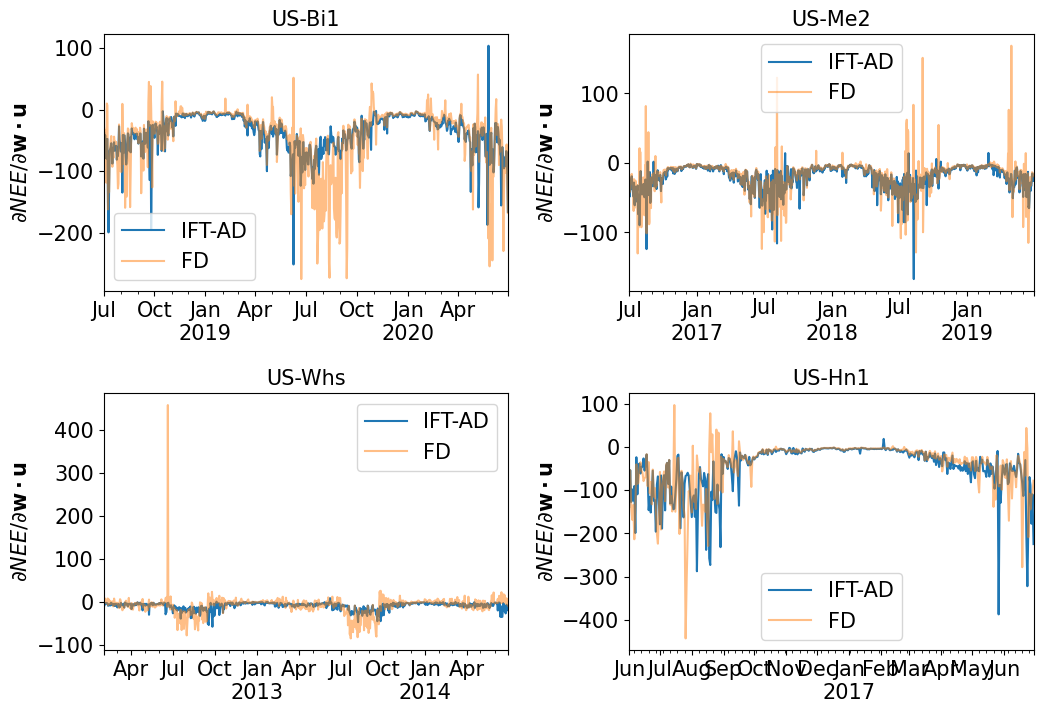

In [9]:
# case = 'PB-1L-0.5'
case = "test-model"
for varn in varn_set:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for i, site in enumerate(sites):
        ax = axes[i]
        ad = df_sa_set[site][f"{varn}:{case}"]["IFT-AD"].resample("D").mean()
        fd = df_sa_set[site][f"{varn}:{case}"]["FD"].resample("D").mean()
        # ad[np.abs(ad) > 1e5] = np.nan
        ad.plot(ax=ax, label="IFT-AD")
        fd.plot(ax=ax, alpha=0.5, label="FD")
        ax.set(title=f"{site}", ylabel=rf"$\partial {varn} / \partial \bf w \cdot \bf u$")
        ax.legend()
        # plt.suptitle(f"Directional derivative on {varn}")
    plt.subplots_adjust(wspace=0.3, hspace=0.4)


# Exam the parameter values

In [23]:
# Get parameters
labels, df_para = [], []
for i,site in enumerate(sites):
    # Stay in the current directory
    os.chdir(dir_mother)

    for case in cases:
        if i!=0 and case=='test-model': continue
        dir_case = dir_mother / f"{site}" / case
        f_configs = dir_case / "configs.json"
        
        # Load the model
        model, _, _, _, _ = load_model(f_configs)
        p_values = []
        for p in subpara:
            p_values.append(getattr(model.para, p))
        df_para.append(p_values)
        labels.append(f"{site}-{case}")

df_para = pd.DataFrame(np.array(df_para).T, index=subpara_labels, columns=labels)


/global/cfs/cdirs/m1800/peishi/JAX-CanVeg/src/jax_canveg/subjects/initialization_update.py:350: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)
/global/cfs/cdirs/m1800/peishi/JAX-CanVeg/src/jax_canveg/subjects/initialization_update.py:350: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)
/global/cfs/cdirs/m1800/peishi/JAX-CanVeg/src/jax_canveg/subjects/initialization_update.py:350: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both

In [24]:
df_para

,US-Bi1-test-model,US-Bi1-PB-ML-0.5,US-Bi1-Hybrid-ML-0.5,US-Me2-PB-ML-0.5,US-Me2-Hybrid-ML-0.5,US-Whs-PB-ML-0.5,US-Whs-Hybrid-ML-0.5,US-Hn1-PB-ML-0.5,US-Hn1-Hybrid-ML-0.5
$ϵ$,0.98,0.610539,0.408440,0.082220,0.034403,0.892069,0.668000,0.856946,0.985366
$r_{PAR}$,0.05,0.003260,0.000050,0.165755,0.162034,0.245417,0.176747,0.237571,0.235351
$τ_{PAR}$,0.05,0.385462,0.245558,0.197284,0.000050,0.284472,0.185984,0.001449,0.004396
$r_{NIR}$,0.60,0.003277,0.324428,0.207544,0.600770,0.515487,0.577321,0.655693,0.747512
$τ_{NIR}$,0.20,0.000050,0.000050,0.147044,0.222542,0.145279,0.162199,0.239368,0.346391
$m$,0.05,0.061653,0.024225,0.014515,0.000050,0.000050,0.000050,0.006895,0.010334
$g_0$,0.04,0.084027,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.093500
$l$,0.22,0.183418,0.167896,0.113645,0.123297,0.007664,0.105046,0.032818,0.016527
$α$,8.17,8.458918,8.397135,8.199928,8.060039,8.214520,8.009865,7.965953,7.937949
$\Omega$,0.95,1.000000,1.000000,0.786013,0.871000,0.736352,0.759176,0.705907,0.748013


In [32]:
print(df_para.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.1e}".format,
)) 

\begin{tabular}{lrrrrrrrrr}
\toprule
 & US-Bi1-test-model & US-Bi1-PB-ML-0.5 & US-Bi1-Hybrid-ML-0.5 & US-Me2-PB-ML-0.5 & US-Me2-Hybrid-ML-0.5 & US-Whs-PB-ML-0.5 & US-Whs-Hybrid-ML-0.5 & US-Hn1-PB-ML-0.5 & US-Hn1-Hybrid-ML-0.5 \\
\midrule
$ϵ$ & 9.8e-01 & 6.1e-01 & 4.1e-01 & 8.2e-02 & 3.4e-02 & 8.9e-01 & 6.7e-01 & 8.6e-01 & 9.9e-01 \\
$r_{PAR}$ & 5.0e-02 & 3.3e-03 & 5.0e-05 & 1.7e-01 & 1.6e-01 & 2.5e-01 & 1.8e-01 & 2.4e-01 & 2.4e-01 \\
$τ_{PAR}$ & 5.0e-02 & 3.9e-01 & 2.5e-01 & 2.0e-01 & 5.0e-05 & 2.8e-01 & 1.9e-01 & 1.4e-03 & 4.4e-03 \\
$r_{NIR}$ & 6.0e-01 & 3.3e-03 & 3.2e-01 & 2.1e-01 & 6.0e-01 & 5.2e-01 & 5.8e-01 & 6.6e-01 & 7.5e-01 \\
$τ_{NIR}$ & 2.0e-01 & 5.0e-05 & 5.0e-05 & 1.5e-01 & 2.2e-01 & 1.5e-01 & 1.6e-01 & 2.4e-01 & 3.5e-01 \\
$m$ & 5.0e-02 & 6.2e-02 & 2.4e-02 & 1.5e-02 & 5.0e-05 & 5.0e-05 & 5.0e-05 & 6.9e-03 & 1.0e-02 \\
$g_0$ & 4.0e-02 & 8.4e-02 & 1.0e-01 & 1.0e-01 & 1.0e-01 & 1.0e-01 & 1.0e-01 & 1.0e-01 & 9.3e-02 \\
$l$ & 2.2e-01 & 1.8e-01 & 1.7e-01 & 1.1e-01 & 1.2e-01 & 7